In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/saved_model.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/keras_metadata.pb
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/assets/vocab.txt
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.index
/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/variables/variables.data-00000-of-00001
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-512-a-8/2/saved_model.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-512-a-8/2/keras_metadata.pb
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-512-a-8/2/assets/vocab.txt
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-512-a-8/2/variables/variables.index
/kaggle/input/bert/tensorflow2/bert-en-uncased-l-10-h-512-a-8/2/variables/variables.data-00000-of-00001
/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [3]:
train_prompts_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_essays_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays_df = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')

In [4]:
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
train_prompts_df.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [6]:
test_essays_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [7]:
train_essays_df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

<Axes: xlabel='generated', ylabel='count'>

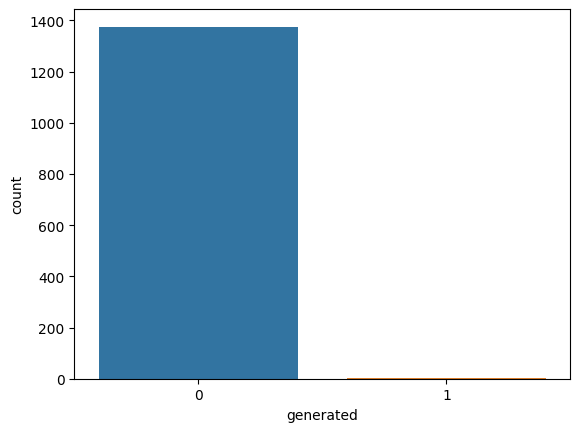

In [8]:
sns.countplot(x = train_essays_df['generated'])

<Axes: xlabel='prompt_id', ylabel='count'>

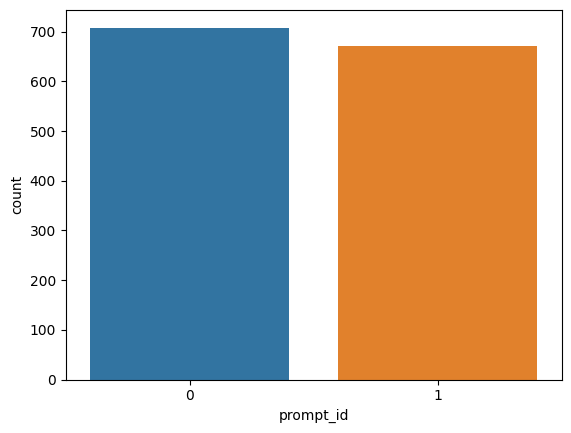

In [9]:
sns.countplot(x = train_essays_df['prompt_id'])

In [10]:
train_essay_df_ex = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [11]:
train_essay_df_ex.rename(columns = {"label":"generated"}, inplace = True)

In [12]:
train_essay_df_ex['generated'].value_counts()

generated
0    27371
1    17497
Name: count, dtype: int64

<Axes: xlabel='generated', ylabel='count'>

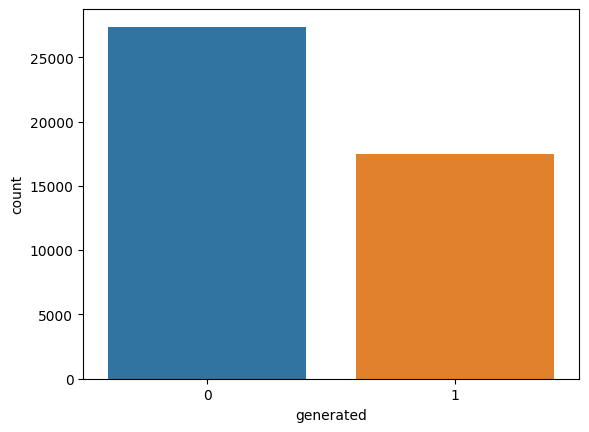

In [13]:
sns.countplot(x = train_essay_df_ex['generated'])

In [14]:
df_train_1 = pd.concat([train_essays_df[["text", "generated"]], train_essay_df_ex[["text", "generated"]]])

In [15]:
df_train_1.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [16]:
df_train_1['generated'].value_counts()

generated
0    28746
1    17500
Name: count, dtype: int64

<Axes: xlabel='generated', ylabel='count'>

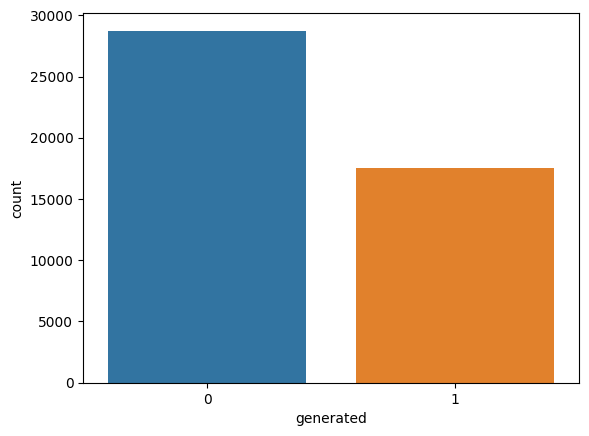

In [17]:
sns.countplot(x = df_train_1['generated'])

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
x_train, x_test ,y_train , y_test = train_test_split(df_train_1.iloc[:,0:2], df_train_1['generated'],test_size=0.2)


In [20]:
x_train['labels'] = y_train
x_test['labels'] = y_test

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

Using TensorFlow backend


In [22]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor_url = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3"
preprocessor= tfhub.KerasLayer(preprocessor_url )
encoder_inputs = preprocessor(text_input)

encoder_url =  "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-512-a-8/versions/2"
encoder = tfhub.KerasLayer(encoder_url,trainable=True)
outputs = encoder(encoder_inputs)

pooled_output = outputs["pooled_output"]      
sequence_output = outputs["sequence_output"] 

dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout1 = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)
dense_3 = tf.keras.layers.Dense(16,activation='relu')(dropout1)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dense_3)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00007),
              loss='binary_crossentropy',
              metrics=["accuracy"])
metric = 'val_accuracy'
checkpoint_filepath = 'checkpoint.hdf5'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'), 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train['text'], x_train['labels'] , batch_size=8,
                    epochs=5 , validation_data=(x_test['text'], x_test['labels']))
model.save("bertmodel")

Epoch 1/5
1463/4625 [========>.....................] - ETA: 2:41:53 - loss: 0.7096 - accuracy: 0.5642

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis = 1))
    
    tn, fp, fn, tp = cm.ravel()
    f1_score = tp/(tp+((fn+fp)/2))
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_label = ["Human", "AI"], cmap = plt.cm.Blues)
    disp.plot(ax = plt.gca(), cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))
    plt.show()

In [ ]:
y_pred_test = model.predict(x_test)

In [ ]:
displayConfusionMatrix(y_test, y_pred_test, "Testing")